In [1]:
import math
import torch
import numpy as np

from guided_diffusion.script_util import create_model
import mrfft

import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm

def update_pbar_desc(pbar, metrics, labels):
    pbar_string = ''
    for metric, label in zip(metrics, labels):
        pbar_string += f'{label}: {metric:.7f}; '
    pbar.set_description(pbar_string)

%matplotlib inline

In [40]:
model = create_model(
    image_size=256,
    num_channels=128,
    num_res_blocks=2,
    channel_mult="",
    learn_sigma=True,
    class_cond=False,
    use_checkpoint=False,
    attention_resolutions="16,8",
    num_heads=4,
    num_head_channels=-1,
    num_heads_upsample=-1,
    use_scale_shift_norm=True,
    dropout=0,
    resblock_updown=False,
    use_fp16=False,
    use_new_attention_order=False,
)

device = torch.device("cuda:0")
model = model.to(device)
model.eval()

betas = np.linspace(0.0001, 0.02, 1000, dtype=np.float64)
betas = torch.from_numpy(betas).float().to(device)

In [41]:
def float2cplx(float_in):
    return np.array(float_in[...,0]+1.0j*float_in[...,1], dtype='complex64')

def cplx2float(cplx_in):
    return np.array(np.stack((cplx_in.real, cplx_in.imag), axis=-1), dtype='float32')


import torch.fft as torch_fft
def _ifft(x):
    x = torch_fft.ifftshift(x, dim=(-2, -1))
    x = torch_fft.ifft2(x, dim=(-2, -1), norm='ortho')
    x = torch_fft.fftshift(x, dim=(-2, -1))
    return x

# Centered, orthogonal fft in torch >= 1.7
def _fft(x):
    x = torch_fft.fftshift(x, dim=(-2, -1))
    x = torch_fft.fft2(x, dim=(-2, -1), norm='ortho')
    x = torch_fft.ifftshift(x, dim=(-2, -1))
    return x

In [42]:
def compute_alpha(beta, t):
    beta = torch.cat([torch.zeros(1).to(beta.device), beta], dim=0)
    a = (1 - beta).cumprod(dim=0).index_select(0, t + 1).view(-1, 1, 1, 1)
    return a


# form RePaint
def get_schedule_jump(T_sampling, travel_length, travel_repeat):

    jumps = {}
    for j in range(0, T_sampling - travel_length, travel_length):
        jumps[j] = travel_repeat - 1

    t = T_sampling
    ts = []

    while t >= 1:
        t = t-1
        ts.append(t)

        if jumps.get(t, 0) > 0:
            jumps[t] = jumps[t] - 1
            for _ in range(travel_length):
                t = t + 1
                ts.append(t)

    ts.append(-1)

    _check_times(ts, -1, T_sampling)

    return ts

def _check_times(times, t_0, T_sampling):
    # Check end
    assert times[0] > times[1], (times[0], times[1])

    # Check beginning
    assert times[-1] == -1, times[-1]

    # Steplength = 1
    for t_last, t_cur in zip(times[:-1], times[1:]):
        assert abs(t_last - t_cur) == 1, (t_last, t_cur)

    # Value range
    for t in times:
        assert t >= t_0, (t, t_0)
        assert t <= T_sampling, (t, T_sampling)

In [43]:
def inverse_data_transform(x):
    x = (x + 1.0) / 2.0
    return x

def data_transform(x):
    x = (2 * x) - 1.0
    return x

In [70]:
import h5py

slice = 1

data = np.load('/home/jupyter-huangshoujin/MRIGDP_paper/fastmri_data/real/file_brain_AXT2_207_2070066.npy',allow_pickle=True).item()
mag = data['rss'][slice]

mag = mag / mag.max()
mag = torch.from_numpy(mag.astype(np.float32))[None,None].to(device)
mag = torch.nn.functional.interpolate(mag,size=[384,384],mode='bilinear')

In [87]:
def ddnm_diffusion(xt, model, b, T, sigma_y, step_size, arg_iters,  cond_func=None):
    skip = 1000 / T
    n = x.size(0)
    losses = []

    times = get_schedule_jump(T, 1, 1)
    time_pairs = list(zip(times[:-1], times[1:]))        

    pbar = tqdm(time_pairs)
    pbar_labels = ['loss', 'mean', 'min', 'max']

    k_init = 0
    b_init = 0
    
    # Reverse diffusion + Nila-DC
    for i, j in pbar:
        i, j = i*skip, j*skip
        if j<0: j=-1 

        t       = (torch.ones(n) * i).to(x.device)
        next_t  = (torch.ones(n) * j).to(x.device)
        at      = compute_alpha(b, t.long())
        at_next = compute_alpha(b, next_t.long())
        sigma_t = (1 - at_next).sqrt()[0, 0, 0, 0]
        a       = at_next.sqrt()[0, 0, 0, 0]
        
        et = model(xt, t)[:, :2]

        xt = (1/at.sqrt()) * (xt - et * (1 - at).sqrt()) # Eq.6

        if cond_func is not None:
            for _ in range(arg_iters): # Fig.2 (a) (for best DC)
                meas_grad = cond_func(xt) 
    
                if sigma_t / a <  sigma_y: # Eq.10 (lambda function)
                    if k_init == 0 and b_init==0:
                        k_init = 0.2 / (-1 * i)
                        b_init = -999 * k_init
                    factor = k_init * (999 - i) + b_init
                else:
                    factor = 1
                
                xt = xt - factor * meas_grad * step_size
        xt_1 = at_next.sqrt() * xt + torch.randn_like(xt) * sigma_t # Eq.11

        metrics = [(meas_grad).norm(), (xt).abs().mean(), (xt).abs().min(), (xt).abs().max()]
        update_pbar_desc(pbar, metrics, pbar_labels)
        xt = xt_1
    return xt

In [92]:
def cond_func(x_val, y):
    with torch.enable_grad():
        x = x_val.detach().requires_grad_(True)

        transform_x = inverse_data_transform(x)
        transform_y = inverse_data_transform(y)

        mse = (torch.sqrt(transform_x[:,0]**2 + transform_x[:,1]**2) - transform_y) ** 2
        mse = mse.mean(dim=(1,2,3)).sum()

        loss =  mse * 1*1e5

        return torch.autograd.grad(loss, x)[0]

grad_params = {'y': data_transform(mag)}
AHA         = partial(cond_func, **grad_params)

N = 2 # High N to get high best visuliazation.
shape = [2,384,384]

print(model.load_state_dict(torch.load('/home/jupyter-huangshoujin/nila_sms/384x384_ema_0.9999_200000.pt', map_location='cpu')))

with torch.no_grad():
    x = torch.randn([N] + shape).to(device)
    x = ddnm_diffusion(x, model, betas, T=1000, sigma_y=0., step_size=2, arg_iters=1, cond_func=AHA)

<All keys matched successfully>


loss: 1.8735489; mean: 1.1875381; min: 0.4768127; max: 2.8746107; : 100%|██████████| 1000/1000 [01:15<00:00, 13.17it/s]


In [93]:
images        = float2cplx(inverse_data_transform(torch.mean(x,dim=(0))).cpu().permute(1,2,0))

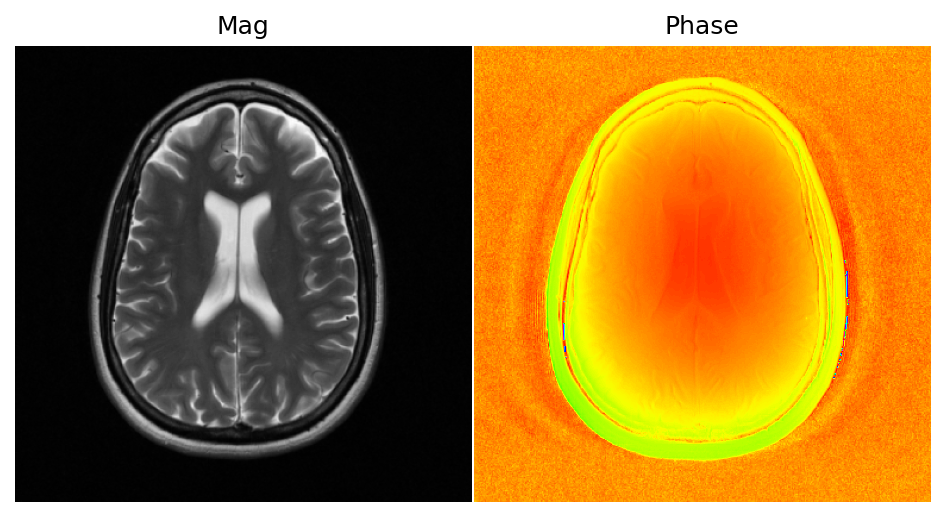

In [94]:
plt.figure(dpi=150)
plt.subplot(1,2,1)
plt.imshow(np.abs(images)[::-1],cmap='gray')
plt.title('Mag')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(np.angle(images)[::-1],cmap='hsv')
plt.title('Phase')
plt.axis('off')

plt.tight_layout(w_pad=0.1)
plt.show()